# ConvNeXt semi-supervised approach

<b> What is done here? <b>

* Model Architecture:
** Add a convolutional decoder to reconstruct the input image from the embeddings.
** Implement a reconstruction loss based on the pixel-wise difference between the input image and its reconstruction.
** Add a classification head to predict the class.

* Loss Function:
** Classification Loss: Only apply for non-screening classes (Class 0, 1, 2) using a mask.
** Reconstruction Loss: Apply for all images (regardless of class), but weight it so that it does not overwhelm the classification loss.


* Training Process:
** Add a mask to handle whether the image corresponds to a screening cell (Class 5) or not.
** During training, use this mask to selectively apply the classification loss to non-screening cells and reconstruction loss to all cells.


* Handling Case 3 (0,1,2,5|balanced_testset):
** Include the screening class (Class 5) in the training set.
** Ensure that for screening cells, the classification loss is masked out, but the reconstruction loss still applies.

In [1]:
!pip install numpy==1.26.4 torch==2.1.0 torchvision==0.16.0 \
    transformers==4.48.1 pillow==9.2.0 anndata==0.10.3 scanpy==1.9.6 \
    matplotlib gputil leidenalg umap-learn h5py requests \
    "scikit-learn>=0.24" statsmodels==0.14.4 session-info patsy \
    safetensors==0.5.2 tokenizers==0.21.0 huggingface-hub==0.27.1 \
    llvmlite==0.44.0 numba==0.61.0 stdlib-list==0.11.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 18.2 MB 3.2 MB/s eta 0:00:01
     |██████████████▏                 | 296.1 MB 9.8 MB/s eta 0:00:3905

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 670.2 MB 227.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 68.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 129.6 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 132.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 173.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 67.2 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 149.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 153.1 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 169.7 MB/s eta 0:00:01
     |████████████████████████████████| 461 kB 151.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 157.7 MB/s eta 0:00:01
     |████████████████████████████████| 450 kB 163.0 MB/s eta 0:00:01
     |████████████████████████████████| 42.4 MB 155.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 149.6 MB/s eta 0:00:01
     |█████████████

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 410.6 MB 216.8 MB/s eta 0:00:01
     |████████████████████████████████| 124.2 MB 64 kB/s eta 0:00:0101
     |████████████████████████▉       | 162.7 MB 168.6 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 56.5 MB 162.8 MB/s eta 0:00:01
     |███████████▏                    | 254.4 MB 235.1 MB/s eta 0:00:03

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |██████████████████▍             | 420.2 MB 4.2 MB/s eta 0:01:1502

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 731.7 MB 8.4 MB/s eta 0:00:0101
     |████████████████████████████████| 14.1 MB 170.3 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 109.1 MB/s eta 0:00:01
     |████████████████████████████████| 39.3 MB 166.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 98.6 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 119.8 MB/s eta 0:00:01
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=a9845bba1cbafaa59eee85b620bc545715dcd57f2f2d15bfb5dfdf2cf1b9479f
  Stored in directory: /tmp/pip-ephem-wheel-cache-dp9p83ld/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8042 sha256=bb11818d0647cb5be6c99bb935ed8389369f6a7006486306c54863a08bc13c54
  Stored in directory: /tmp/pip-ephem-wheel-cache-dp9p83ld/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully buil

In [1]:
!pip install matplotlib-venn matplotlib numpy upsetplot venn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 40 kB 2.4 MB/s eta 0:00:01
  distutils: /tmp/pip-build-env-4j8zqe4k/normal/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-4j8zqe4k/normal/local/lib/python3.10/dist-packages
  distutils: /tmp/pip-build-env-4j8zqe4k/normal/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-4j8zqe4k/normal/local/lib/python3.10/dist-packages
  user = False
  home = None
  root = None
  prefix = '/tmp/pip-build-env-4j8zqe4k/normal'
  distutils: /tmp/pip-build-env-4j8zqe4k/overlay/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-4j8zqe4k/overlay/local/lib/python3.10/dist-packages
  distutils: /tmp/pip-build-env-4j8zqe4k/overlay/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-4j8zqe4k/overlay/local/lib/python3.10/dist-packages
  user = False
  home = None
  root = None
  prefix = '/tmp/pip-build-env-4j8zqe4k/overlay'
  Installing build dependencies .

In [3]:
import numpy
print(numpy.__version__)

1.26.4


In [2]:
import os
import re
import glob
import random
import pandas as pd
import pickle
from collections import Counter

# Third-party imports
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, utils
import numpy as np
import h5py
import umap
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import requests
import torch.nn.functional as F
import torch.optim as optim
import pickle
import wandb
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import torch
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Transformers library imports
from transformers import AutoImageProcessor, ConvNextModel, ConvNextConfig

# Project-specific imports
from sparcscore.ml.datasets import HDF5SingleCellDataset
from sparcscore.ml.transforms import RandomRotation, GaussianNoise, ChannelReducer, ChannelSelector
from sparcscore.ml.utils import combine_datasets_balanced
#from sparcscore.ml.pretrained_models import autophagy_classifier2_1

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
class ConvNextWithCustomFCandDecoder(ConvNextModel):
    def __init__(self, config, num_classes=3):
        super().__init__(config)
        
        # Fc classification head
        self.fc = nn.Linear(config.hidden_sizes[-1], num_classes)
        
        # Decoder 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(config.hidden_sizes[-1], 512, kernel_size=4, stride=2, padding=1),  # 1x1 -> 2x2
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)  # 16x16 -> 32x32 (last layer to RGB channels!!!)
        )
    
    def forward(self, pixel_values, **kwargs):
        # extract features
        outputs = super().forward(pixel_values, **kwargs)
        
        # Extract the embeddings 
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Fallback to mean pooling
        
        # Classification 
        logits = self.fc(embeddings)
        
        # Reshape embeddings fore decoder 
        embeddings_reshaped = embeddings.unsqueeze(-1).unsqueeze(-1)  # Reshaping to [batch_size, channels, 1, 1]
        
        # Image reconstruction
        reconstructed_image = self.decoder(embeddings_reshaped)
        
        # Ensure output is the same size as input!!
        reconstructed_image = nn.functional.interpolate(reconstructed_image, size=(128, 128), mode='bilinear', align_corners=False)
        
        return logits, embeddings, reconstructed_image

In [3]:
# Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = ConvNextConfig.from_pretrained("facebook/convnext-xlarge-224-22k")

model = ConvNextWithCustomFCandDecoder.from_pretrained("facebook/convnext-xlarge-224-22k", config=config, num_classes=3)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ConvNextWithCustomFCandDecoder were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.decoder.0.bias', 'convnext.decoder.0.weight', 'convnext.decoder.2.bias', 'convnext.decoder.2.weight', 'convnext.decoder.4.bias', 'convnext.decoder.4.weight', 'convnext.decoder.6.bias', 'convnext.decoder.6.weight', 'convnext.decoder.8.bias', 'convnext.decoder.8.weight', 'convnext.fc.bias', 'convnext.fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextWithCustomFCandDecoder(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=T

In [4]:
full_hdf5_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_0d.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5'],
    dir_labels=[4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 3426407
0: 407464
1: 209030
2: 400000
3: 9346
4: 7476
5: 2393091


In [5]:
def sample_cells(dataset, class_label, n_samples, exclude_indices=[]):
    # Get all valid entries for the given class_label
    valid_entries = [entry for entry in dataset.data_locator if entry[0] == class_label]
    
    # entry[2] gives the index within that specific dataset
    cell_indices = [(entry[1], entry[2]) for entry in valid_entries]  # (handle_id, cell_index) tuple
    
    # Remove excluded indices 
    cell_indices = [ci for ci in cell_indices if ci[1] not in exclude_indices]

    # ccheck if the available cells are fewer than requested
    if len(cell_indices) < n_samples:
        print(f"Warning: Requested {n_samples} samples, but only {len(cell_indices)} available.")
        n_samples = len(cell_indices)
    
    sampled_indices = random.sample(cell_indices, n_samples) # Returns (handle_id, cell_index) pairs
    
    return sampled_indices  

In [6]:
def create_trainset(dataset, filename_template, testset_indices, class_labels, samples_per_class):
    trainset_indices = {}
    testset_all_indices = set([(entry[0], entry[1]) for entries in testset_indices.values() for entry in entries])

    for class_label in class_labels:
        print("Doing class " + str(class_label) + " right now...")
        n_samples = samples_per_class[class_label]
        sampled_cell_indices = sample_cells(dataset, class_label, n_samples, exclude_indices=testset_all_indices)
        trainset_indices[class_label] = sampled_cell_indices
        
        filename = filename_template.format(label=class_label)
        with h5py.File(filename, 'w') as f:
            cell_data_list, cell_index_list, annotation_list = [], [], []
            local_index = 0
            
            for _, (handle_id, cell_index) in enumerate(sampled_cell_indices):
                entry = next((entry for entry in dataset.data_locator if entry[1] == handle_id and entry[2] == cell_index), None)
                if entry is None:
                    continue

                try:
                    data = dataset.handle_list[handle_id][cell_index] 
                except KeyError:
                    continue

                label = entry[0]
                cell_data_list.append(data)
                cell_index_list.append([local_index, local_index])
                annotation_list.append([str(local_index).encode(), str(cell_index).encode(), str(label).encode()])
                local_index += 1  

            if cell_data_list:
                f.create_dataset('single_cell_data', data=np.array(cell_data_list, dtype='float16'))
                f.create_dataset('single_cell_index', data=np.array(cell_index_list, dtype=np.uint64))
                f.create_dataset('annotation', data=np.array(annotation_list, dtype='S'))

    return trainset_indices

In [7]:
# Load the testset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_indices.pkl', 'rb') as f:
    testset_indices = pickle.load(f)

In [8]:
# Define dataset structure
train_class_labels = [0, 1, 2, 5]
samples_per_class = {0: 2000, 1: 2000, 2: 2000, 5: 10000}
batch_size = 64

In [ ]:
# Create training set with separate files for selected class labels
train_filename_template = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case3_balanced_trainingset_big/trainset_{label}.h5'
trainset_indices = create_trainset(full_hdf5_data, train_filename_template, testset_indices, train_class_labels, samples_per_class)

Doing class 0 right now...
Doing class 1 right now...
Doing class 2 right now...
Doing class 5 right now...


In [9]:
balanced_trainset_class_0_1_2_and_5 = HDF5SingleCellDataset(
    dir_list=[f'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case3_balanced_trainingset_big/trainset_{label}.h5' for label in train_class_labels],
    dir_labels=train_class_labels, 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case3_balanced_trainingset_big/',  
    select_channel=4,  # Select the 5th channel
    return_id=True
)

Total: 16000
0: 2000
1: 2000
2: 2000
5: 10000


In [3]:
def load_dataset(save_path, batch_size):
    """
    Load dataset with images, labels, and cell IDs.

    Parameters:
    - save_path: Path where the dataset is stored
    - batch_size: Batch size for DataLoader

    Returns:
    - DataLoader for the dataset
    """
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)

    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Loaded dataset from {save_path}")
    return data_loader

# Load the balanced test dataset
test_data_loader = load_dataset(
    "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset_big.pt",
    batch_size=64
)

Loaded dataset from /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset_big.pt


### Case 3 (0,1,2,5 | testset)


1. Create a new trainingset_big

* 1000 instances each for classes 0, 1, and 2.
* 10,000 instances for class 5.


2. Modify the Loss Calculation & Weighting

* Since class 5 has 10x more instances than classes 0, 1, and 2, loss contributions need to be reweighted.
* Reweighting Step 1: Balance classification and reconstruction loss contributions to make it 50:50.
* Reweighting Step 2: Normalize MSE and CrossEntropy since MSE is naturally larger in magnitude.

3: Log Metrics to WandB and TensorBoard

* Losses: Classification loss, reconstruction loss, total loss.


In [11]:
!ls -l /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/

total 3
drwxrwx--- 2 di93quv pn36po 4096 Sep  9 13:35 case1_balanced_trainingset
drwxrwx--- 2 di93quv pn36po 4096 Jan  7 15:22 case1_balanced_trainingset_small
drwxrwx--- 2 di93quv pn36po 4096 Feb  1 14:55 case2_balanced_trainingset_small
drwxrwx--- 2 di93quv pn36po 4096 Mar  6 12:33 case3_balanced_trainingset_big
drwxrwx--- 2 di93quv pn36po 4096 Feb 26 16:31 case3_balanced_trainingset_small


In [10]:
!mkdir /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case3_balanced_trainingset_big

In [ ]:
# Save the trainset_indices to a file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case3_balanced_trainingset_big/trainset_indices_big.pkl', 'wb') as f:
    pickle.dump(trainset_indices, f)

In [11]:
# Load the trainset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case3_balanced_trainingset_big/trainset_indices_big.pkl', 'rb') as f:
    trainset_indices = pickle.load(f)

### Run semi-supervised setting

In [18]:
import torch
torch.cuda.empty_cache()

In [15]:
# Load configuration for ConvNext
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = ConvNextConfig.from_pretrained("facebook/convnext-xlarge-224-22k")

model = ConvNextWithCustomFCandDecoder.from_pretrained("facebook/convnext-xlarge-224-22k", config=config, num_classes=4)
model.to(device)

Some weights of ConvNextWithCustomFCandDecoder were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.decoder.0.bias', 'convnext.decoder.0.weight', 'convnext.decoder.2.bias', 'convnext.decoder.2.weight', 'convnext.decoder.4.bias', 'convnext.decoder.4.weight', 'convnext.decoder.6.bias', 'convnext.decoder.6.weight', 'convnext.decoder.8.bias', 'convnext.decoder.8.weight', 'convnext.fc.bias', 'convnext.fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextWithCustomFCandDecoder(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=T

In [ ]:
train_data = balanced_trainset_class_0_1_2_and_5
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [17]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1) 

In [22]:
#device = "cpu"
device

device(type='cuda')

In [10]:
tensorboard_writer = SummaryWriter("runs/cell_classification")

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=1e-5)
classification_criterion = nn.CrossEntropyLoss()
mse_criterion = nn.MSELoss()

# Reconstruction loss scaling
initial_weight = 0.1  
final_weight = 0.5 
total_epochs = 2  

# Training
model.train()

for epoch in range(total_epochs):
    print(f"Epoch {epoch + 1}/{total_epochs}")
    
    # Track all metrics
    all_train_labels, all_train_preds = [], []
    
    for batch_idx, (inputs, labels, _) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = convert_to_rgb(inputs)  

        optimizer.zero_grad()
        logits, _, reconstructed_image = model(inputs)

        # Classification loss (only for non-background class 5)
        classification_mask = labels != 5
        classification_loss = classification_criterion(logits[classification_mask], labels[classification_mask]) if classification_mask.any() else torch.tensor(0.0, device=device)
        
        # Reconstruction loss
        reconstruction_loss = mse_criterion(reconstructed_image, inputs)  

        # Gradually increase reconstruction weight
        epoch_factor = min(epoch / total_epochs, 1.0)
        reconstruction_loss_weight = initial_weight + (final_weight - initial_weight) * epoch_factor
        total_loss = classification_loss + reconstruction_loss_weight * reconstruction_loss

        total_loss.backward()
        optimizer.step()

        # Track predictions and labels
        preds = logits.argmax(dim=1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())

        # Log metrics per batch
        tensorboard_writer.add_scalar("Loss/classification", classification_loss.item(), batch_idx + epoch * len(train_loader))
        tensorboard_writer.add_scalar("Loss/reconstruction", reconstruction_loss.item(), batch_idx + epoch * len(train_loader))
        tensorboard_writer.add_scalar("Loss/total", total_loss.item(), batch_idx + epoch * len(train_loader))
    
    # Compute metrics per epoch
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_bal_acc = balanced_accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_precision = precision_score(all_train_labels, all_train_preds, average='macro')
    train_recall = recall_score(all_train_labels, all_train_preds, average='macro')

    # Loggig training metrics
    tensorboard_writer.add_scalar("Metrics/train_accuracy", train_acc, epoch)
    tensorboard_writer.add_scalar("Metrics/train_balanced_accuracy", train_bal_acc, epoch)
    tensorboard_writer.add_scalar("Metrics/train_f1", train_f1, epoch)
    tensorboard_writer.add_scalar("Metrics/train_precision", train_precision, epoch)
    tensorboard_writer.add_scalar("Metrics/train_recall", train_recall, epoch)

    print(f"Train Accuracy: {train_acc:.4f}, Balanced Accuracy: {train_bal_acc:.4f}, F1 Score: {train_f1:.4f}")

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 0.6704, Balanced Accuracy: 0.6704, F1 Score: 0.4738
Epoch 2/2
Train Accuracy: 0.7096, Balanced Accuracy: 0.7096, F1 Score: 0.6287


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:329: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [1]:
!nvidia-smi

Thu Mar 13 17:19:35 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-SXM2-16GB           On  | 00000000:06:00.0 Off |                    0 |
| N/A   38C    P0              33W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!kill 2307607      

In [11]:
# Save trained model
torch.save(model.state_dict(), "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_model/semisupervised_cell_model_case_3.pth") # want only weights!
#torch.save(model, "cell_classification_model_full.pth") # full architecture

In [18]:
# Load the saved weights
checkpoint_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_model/semisupervised_cell_model_case_3.pth"

model.load_state_dict(torch.load(checkpoint_path))
model.to(device)

ConvNextWithCustomFCandDecoder(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=T

In [13]:
#Inference
model.eval()

# Initialize tensorboard
tensorboard_writer = SummaryWriter("runs/cell_classification")


#lists for storing stuff
embeddings = []
labels_list = []
cell_ids_list = []
all_labels, all_preds = [], []

with torch.no_grad():
    for inputs, labels, cell_ids in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = convert_to_rgb(inputs) 

        # Extract embeddings & logits from model
        logits, embedding_output, _ = model(inputs)
        preds = logits.argmax(dim=1)

        # Store data
        embeddings.append(embedding_output.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        cell_ids_list.append(cell_ids.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0)

# Compute Test Metrics
test_acc = accuracy_score(all_labels, all_preds)
test_bal_acc = balanced_accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')
test_precision = precision_score(all_labels, all_preds, average='macro')
test_recall = recall_score(all_labels, all_preds, average='macro')

#Log Metrics to TensorBoard
tensorboard_writer.add_scalar("Metrics/test_accuracy", test_acc)
tensorboard_writer.add_scalar("Metrics/test_balanced_accuracy", test_bal_acc)
tensorboard_writer.add_scalar("Metrics/test_f1", test_f1)
tensorboard_writer.add_scalar("Metrics/test_precision", test_precision)
tensorboard_writer.add_scalar("Metrics/test_recall", test_recall)

print(f"Test Accuracy: {test_acc:.4f}, Balanced Accuracy: {test_bal_acc:.4f}, F1 Score: {test_f1:.4f}")

Test Accuracy: 0.2903, Balanced Accuracy: 0.4839, F1 Score: 0.2973


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Save embeddings, labels, and cell IDs
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/"
file_name = "semisupervised_case3.pkl"
os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, file_name), 'wb') as f:
    pickle.dump({'embeddings': embeddings, 'labels': labels_list, 'cell_ids': cell_ids_list}, f)

print(f"Saved embeddings, labels, and cell_ids to {os.path.join(save_path, file_name)}")

Saved embeddings, labels, and cell_ids to /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/semisupervised_case3.pkl


In [5]:
# Define the save path and file name
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/"
file_name = "semisupervised_case3.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

Loaded embeddings shape: (20000, 2048)
Loaded labels shape: (20000,)
Loaded cell_ids shape: (20000,)


In [4]:
# UMAP
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(embeddings_flat)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


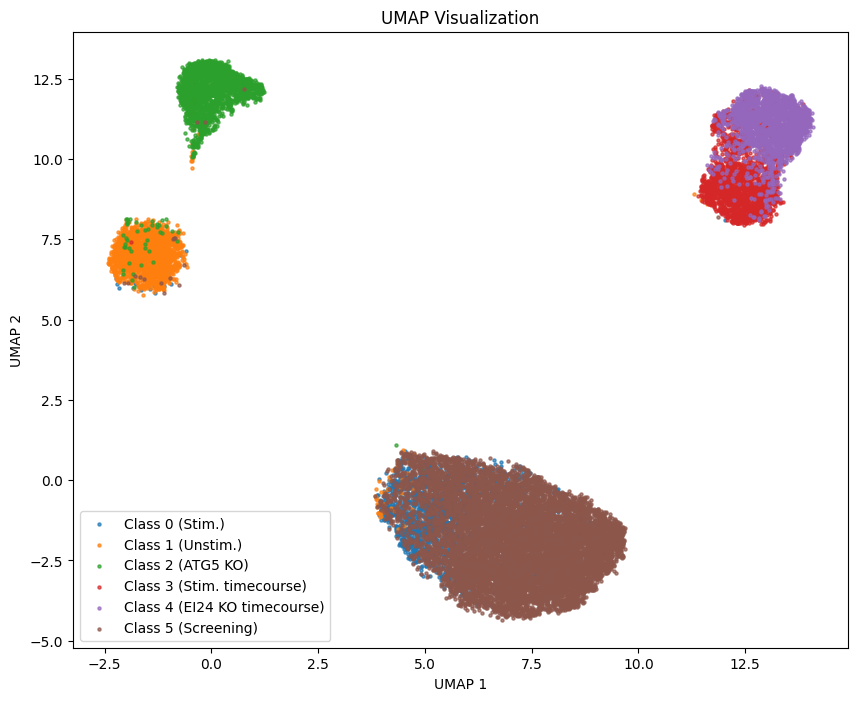

In [59]:
# Class labels
class_labels = [
    "Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 KO)", 
    "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"
]

plt.figure(figsize=(10, 8))

for i, label in enumerate(class_labels):
    idx = labels_list == i 
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5, alpha=0.7)

plt.legend()
plt.title("UMAP Visualization")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Remove grid
plt.grid(False)
plt.show()

In [60]:
#Save UMAP
umap_save_path = "./semisupervised_convnext/umap_testset_10k.png"
plt.savefig(umap_save_path, bbox_inches='tight', dpi=300)
plt.close()  

In [ ]:
#Log UMAP to TensorBoard
image = Image.open(umap_save_path)
image = np.array(image)
tensorboard_writer.add_image("UMAP on 2k-rest-10k-screening testset", torch.tensor(image).permute(2, 0, 1), dataformats="CHW")
tensorboard_writer.close()

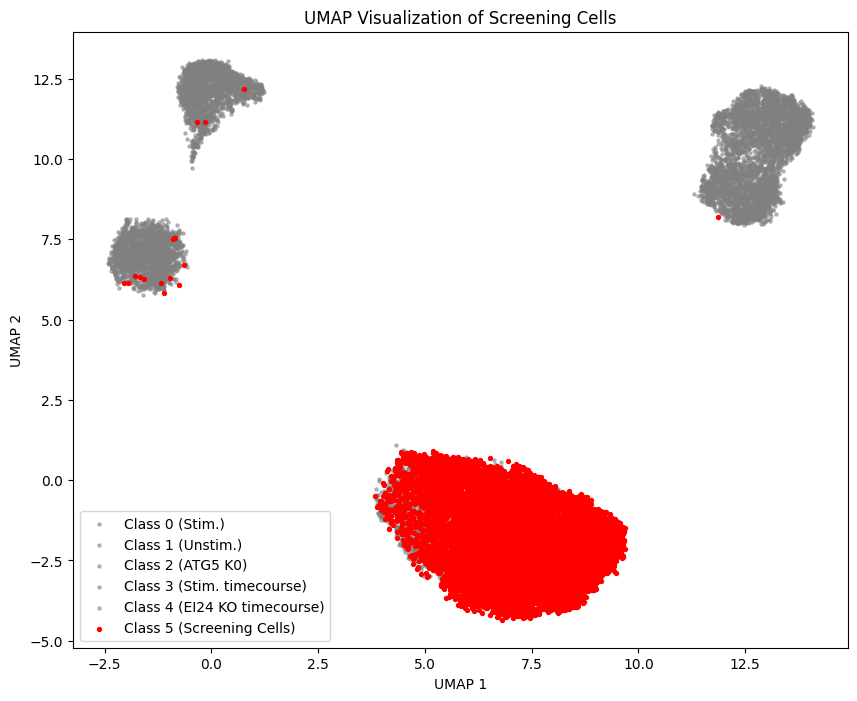

In [61]:
# Class labels
class_labels = [
    "Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", 
    "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"
]

plt.figure(figsize=(10, 8))

# Plot all other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Excluding "Screening" class
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5, alpha=0.5)

# Plot Screening cells in red
screening_idx = labels_list == 5
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], color='red', label='Class 5 (Screening Cells)', s=8)
plt.legend()
plt.title("UMAP Visualization of Screening Cells")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Remove grid
plt.grid(False)
plt.show()

In [63]:
class_labels = [
    "Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", 
    "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"
]

# Parameters for kNN and Outlier Detection
k = 10  # number of nearest neighbors
n = 20  # number of outliers to find

# Extract the UMAP result and labels
x_coords = np.asarray(umap_result[:, 0])
y_coords = np.asarray(umap_result[:, 1])
labels = np.asarray(labels_list)
cell_ids_array = np.asarray(cell_ids_list, dtype=str)

# Identify screening cells (Class 5)
screening_idx = labels == 5
screening_coords = np.column_stack((x_coords[screening_idx], y_coords[screening_idx]))

# Find the dense cluster of screening cells (non-hit control) using kNN
nbrs = NearestNeighbors(n_neighbors=k).fit(screening_coords)
distances, _ = nbrs.kneighbors(screening_coords)

# Compute the mean distance to k nearest neighbors for each cell
avg_knn_dist = distances.mean(axis=1)

# Identify the top n outliers with the biggest kNN distances
outlier_indices = np.argsort(avg_knn_dist)[-n:]

# Get the cell IDs of the outliers
outlier_cell_ids = cell_ids_array[screening_idx][outlier_indices] 

In [64]:
# Save outlier cell IDs to a file
save_path = "./semisupervised_convnext/knn_screening_hits.txt"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.savetxt(save_path, outlier_cell_ids, fmt="%s")
print(f"Saved {len(outlier_cell_ids)} potential screening hits to {save_path}")

Saved 20 potential screening hits to ./semisupervised_convnext/knn_screening_hits.txt


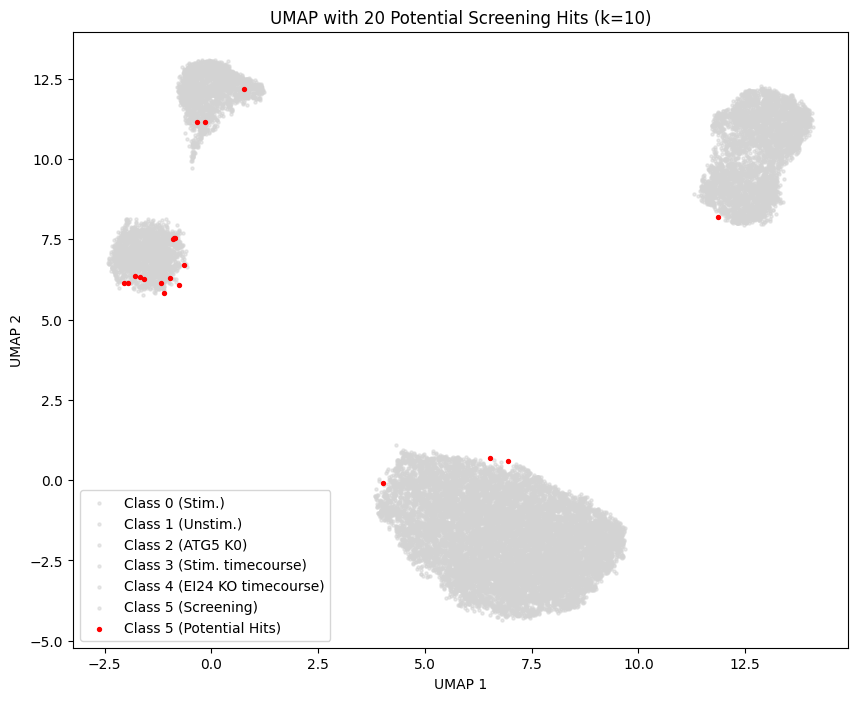

In [65]:
# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot all classes (including screening) in light grey
for i, label in enumerate(class_labels):  
    idx = labels == i
    plt.scatter(x_coords[idx], y_coords[idx], color='lightgrey', label=label, s=5, alpha=0.5)

# Plot Screening cells that are identified as potential hits using kNN in red
plt.scatter(screening_coords[outlier_indices, 0], screening_coords[outlier_indices, 1], 
            color='red', label="Class 5 (Potential Hits)", s=8, edgecolors='red')
plt.legend()
plt.title(f"UMAP with {n} Potential Screening Hits (k={k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.show()

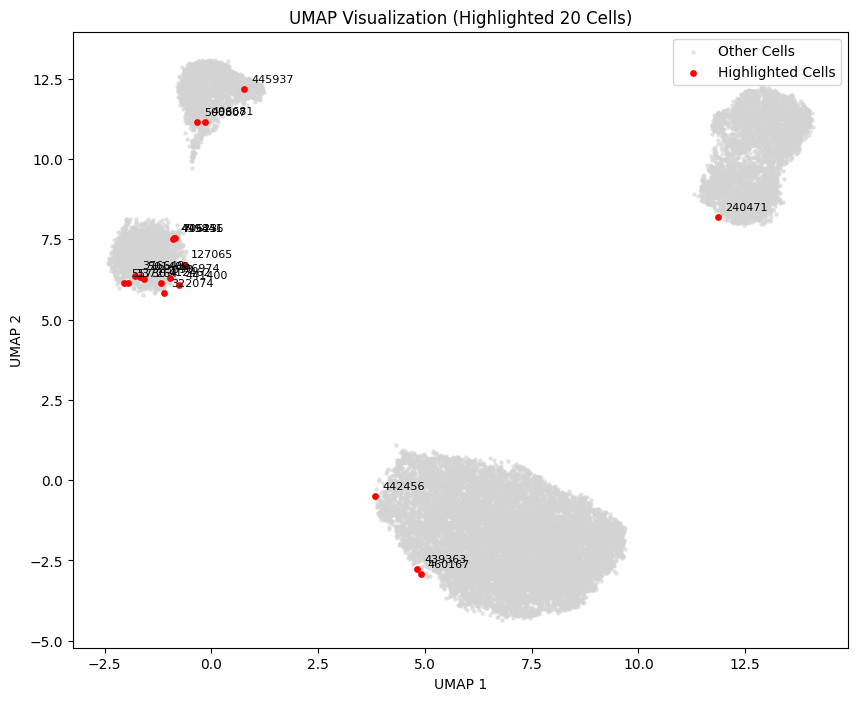

In [66]:
highlighted_cell_ids = np.array([323098,
500807,
70623,
441400,
445937,
460167,
501489,
496681,
337264,
322074,
55730,
499841,
376649,
439363,
445456,
442456,
127065,
496974,
240471,
412462]).astype(str)  

cell_ids_array = cell_ids_array.astype(str)
highlighted_indices = np.isin(cell_ids_array, highlighted_cell_ids)

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='lightgrey', label="Other Cells", s=5, alpha=0.5)

plt.scatter(highlighted_x, highlighted_y, color='red', edgecolors='red', s=15, label='Highlighted Cells', marker='o')

for i, txt in enumerate(highlighted_cell_ids):
    plt.annotate(txt, (highlighted_x[i], highlighted_y[i]), fontsize=8, color='black', xytext=(5,5), textcoords='offset points')

plt.legend()
plt.title('UMAP Visualization (Highlighted 20 Cells)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [67]:
def visualize_and_save_cells(outlier_cell_ids, data_loader, save_path="./semisupervised_convnext/knn_screening_hits_images.png"):
    """Visualizes images for the outlier cell IDs in a dynamic grid, saves, and shows the result."""
    if not outlier_cell_ids:
        print("No outlier cell images to visualize.")
        return

    outlier_cell_ids = set(outlier_cell_ids)  # Convert to set for faster lookups
    num_images = len(outlier_cell_ids)
    
    # Determine grid size dynamically
    grid_cols = 10  
    grid_rows = int(np.ceil(num_images / grid_cols))  
    
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 1.5 * grid_rows))

    image_count = 0
    for images, labels, cell_ids in data_loader:
        for i in range(len(cell_ids)):
            if str(cell_ids[i].item()) in outlier_cell_ids:
                row, col = divmod(image_count, grid_cols)
                ax = axes[row, col] if grid_rows > 1 else axes[col]

                image_data = images[i].cpu().numpy()
                num_channels = image_data.shape[0]

                # If single-channel, show grayscale image
                if num_channels == 1:
                    ax.imshow(image_data[0], cmap='viridis')
                else:
                    ax.imshow(np.moveaxis(image_data, 0, -1))  # Convert from (C, H, W) to (H, W, C)

                ax.set_title(f"ID: {cell_ids[i].item()}", fontsize=8)
                ax.axis("off")

                image_count += 1
                if image_count >= num_images:  
                    break  

        if image_count >= num_images:
            break  

    # Hide unused subplots
    for ax in axes.flat[image_count:]:
        ax.axis("off")

    plt.tight_layout()
    print(f"Outlier Cell Images ({num_images} total)")
    
    # Save the figure
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Saved outlier cell images to {save_path}")
    
    plt.show()

['451082', '502048', '440648', '441400', '460167', '445937', '337264', '496681', '501489', '55730', '322074', '499841', '376649', '445456', '442456', '439363', '127065', '496974', '240471', '412462']
Loaded 20 outlier cell IDs from ./semisupervised_convnext/knn_screening_hits.txt
Outlier Cell Images (20 total)
Saved outlier cell images to ./semisupervised_convnext/knn_screening_hits_images.png


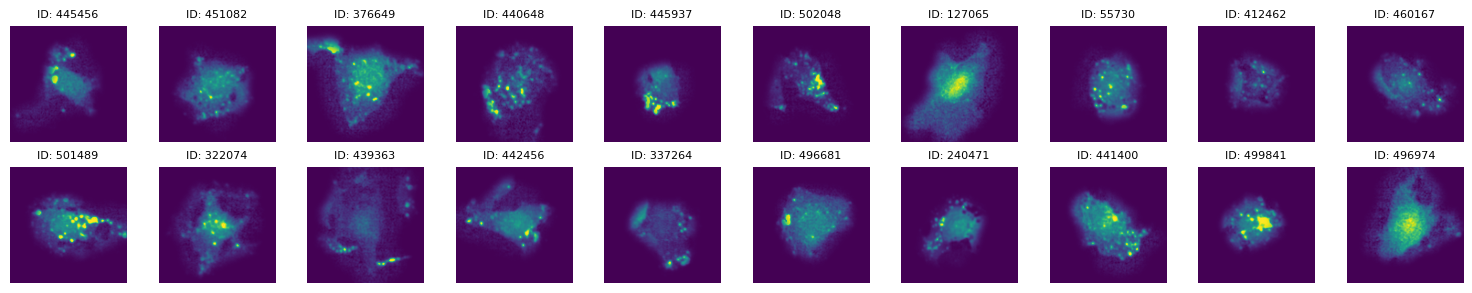

In [70]:
# Load the outlier cell IDs from the saved text file!
knn_outlier_file = "./semisupervised_convnext/knn_screening_hits.txt"
if os.path.exists(knn_outlier_file):
    with open(knn_outlier_file, "r") as f:
        outlier_cell_ids = [line.strip() for line in f.readlines()]
        print(outlier_cell_ids)
    print(f"Loaded {len(outlier_cell_ids)} outlier cell IDs from {knn_outlier_file}")

    # **Visualize and save images for outlier cells**
    visualize_and_save_cells(outlier_cell_ids, test_data_loader, save_path="./semisupervised_convnext/knn_screening_hits_images.png")
else:
    print(f"Outlier cell file not found: {knn_outlier_file}")

In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

def visualize_and_save_cells(outlier_cell_ids, data_loader, scores_df, save_path="./semisupervised_convnext/knn_screening_hits_images.png"):
    """Visualizes images for the outlier cell IDs with scores, saves, and shows the result."""
    if not outlier_cell_ids:
        print("No outlier cell images to visualize.")
        return

    outlier_cell_ids = set(outlier_cell_ids)  # Convert to set for faster lookup
    num_images = len(outlier_cell_ids)

    # Build score lookup dictionary
    scores_df["Cell ID"] = scores_df["Cell ID"].astype(str)
    score_lookup = dict(zip(scores_df["Cell ID"], scores_df["Autophagy Off Score"]))  # Replace with actual column name if different

    # Determine grid size
    grid_cols = 10
    grid_rows = int(np.ceil(num_images / grid_cols))

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 1.5 * grid_rows))
    if grid_rows == 1:
        axes = np.expand_dims(axes, 0)  # Handle case of single row

    image_count = 0
    for images, labels, cell_ids in data_loader:
        for i in range(len(cell_ids)):
            cell_id_str = str(cell_ids[i].item())
            if cell_id_str in outlier_cell_ids:
                row, col = divmod(image_count, grid_cols)
                ax = axes[row, col]

                image_data = images[i].cpu().numpy()
                num_channels = image_data.shape[0]

                if num_channels == 1:
                    ax.imshow(image_data[0], cmap='viridis')
                else:
                    ax.imshow(np.moveaxis(image_data, 0, -1))

                score = score_lookup.get(cell_id_str, "0.9999")
                ax.set_title(f"ID: {cell_id_str}\nScore: {score:.4f}" if score != "0.9999" else f"ID: {cell_id_str}\nScore: 0.9999", fontsize=8)
                ax.axis("off")

                image_count += 1
                if image_count >= num_images:
                    break
        if image_count >= num_images:
            break

    # Hide unused axes
    for ax in axes.flat[image_count:]:
        ax.axis("off")

    plt.tight_layout()
    print(f"Outlier Cell Images ({num_images} total)")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Saved outlier cell images to {save_path}")
    plt.show()

In [ ]:
# Load scores
scores_df = pd.read_csv("autophagy21_classification_scores_big_testset.csv")

# Load outlier cell IDs
knn_outlier_file = "./semisupervised_convnext/knn_screening_hits.txt"
if os.path.exists(knn_outlier_file):
    with open(knn_outlier_file, "r") as f:
        outlier_cell_ids = [line.strip() for line in f.readlines()]
        print(f"Loaded {len(outlier_cell_ids)} outlier cell IDs.")

    visualize_and_save_cells(outlier_cell_ids, test_data_loader, scores_df, save_path="./semisupervised_convnext/knn_screening_hits_images.png")
else:
    print(f"Outlier cell file not found: {knn_outlier_file}")


Loaded 20 outlier cell IDs.
Outlier Cell Images (20 total)
Saved outlier cell images to ./semisupervised_convnext/knn_screening_hits_images.png


In [71]:
#Get the autophagy_2_1 scores
df = pd.read_csv("autophagy21_classification_scores_big_testset.csv")

cell_ids_to_find = ["323098", "500807", "70623", "441400", "445937", "460167", "501489", "496681", "337264", "322074", "55730", "499841", "376649", "439363", "445456", "442456", "127065", "496974", "240471", "412462"]

df["Cell ID"] = df["Cell ID"].astype(str)
filtered_df = df[df["Cell ID"].isin(cell_ids_to_find)]
filtered_df

,Cell ID,Autophagy On Score,Autophagy Off Score
1659,445456,6.755327e-06,0.999993
6104,70623,8.799828e-01,0.120017
6167,445937,5.950180e-05,0.999941
6203,499841,2.958022e-01,0.704198
6329,441400,2.105678e-04,0.999789
6596,412462,4.086442e-04,0.999591
7574,439363,2.535472e-04,0.999746
7750,496681,5.460521e-04,0.999454
8024,240471,1.128008e-04,0.999887
8029,323098,9.987377e-01,0.001262


In [78]:
import numpy as np
import pandas as pd
import umap
import umap.umap_ as umap  # Correct way
import matplotlib.pyplot as plt

# Define binning function based on autophagy_off score
def assign_bin(score):
    if score > 0.99999:
        return "bin 1"
    elif score > 0.999:
        return "bin 2"
    elif score > 0.9975:
        return "bin 3"
    elif score > 0.995:
        return "bin 4"
    elif score > 0.99:
        return "bin 5"
    elif score > 0.98:
        return "bin 6"
    else:
        return "other"

    
# Step 2: Apply binning function to create a new column
df = pd.read_csv("autophagy21_classification_scores_big_testset.csv")
df

cell_ids_to_find = ["323098", "500807", "70623", "441400", "445937", "460167", "501489", "496681", "337264", "322074", "55730", "499841", "376649", "439363", "445456", "442456", "127065", "496974", "240471", "412462"]

# Apply binning function to the dataframe
df["Bin"] = df["Autophagy Off Score"].apply(assign_bin)
df["Cell ID"] = df["Cell ID"].astype(str)
df

,Cell ID,Autophagy On Score,Autophagy Off Score,Bin
0,439,6.700127e-02,9.329987e-01,other
1,293873,5.018042e-07,9.999995e-01,bin 1
2,1437,7.523392e-01,2.476609e-01,other
3,437630,1.878466e-06,9.999981e-01,bin 1
4,80815,9.999956e-01,4.432396e-06,other
...,...,...,...,...
11995,469873,9.998048e-01,1.952647e-04,other
11996,316062,3.255916e-05,9.999675e-01,bin 2
11997,179090,9.619690e-01,3.803107e-02,other
11998,247275,2.832826e-06,9.999971e-01,bin 1


In [79]:
# Merge bin information into filtered_df
filtered_df = df[df["Cell ID"].isin(cell_ids_to_find)]
filtered_df

,Cell ID,Autophagy On Score,Autophagy Off Score,Bin
1659,445456,6.755327e-06,0.999993,bin 1
6104,70623,8.799828e-01,0.120017,other
6167,445937,5.950180e-05,0.999941,bin 2
6203,499841,2.958022e-01,0.704198,other
6329,441400,2.105678e-04,0.999789,bin 2
6596,412462,4.086442e-04,0.999591,bin 2
7574,439363,2.535472e-04,0.999746,bin 2
7750,496681,5.460521e-04,0.999454,bin 2
8024,240471,1.128008e-04,0.999887,bin 2
8029,323098,9.987377e-01,0.001262,other


In [82]:
# Extract indices of highlighted screening cells
cell_ids_array = cell_ids_list.astype(str)  # Convert all cell IDs to string
highlighted_indices = np.isin(cell_ids_array, filtered_df["Cell ID"].values)  # Boolean mask

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

# Merge UMAP results with bin information
highlighted_bins = filtered_df.set_index("Cell ID").loc[cell_ids_array[highlighted_indices], "Bin"].values

# Define colors for bins
bin_colors = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black", 
    "other": "green"
}

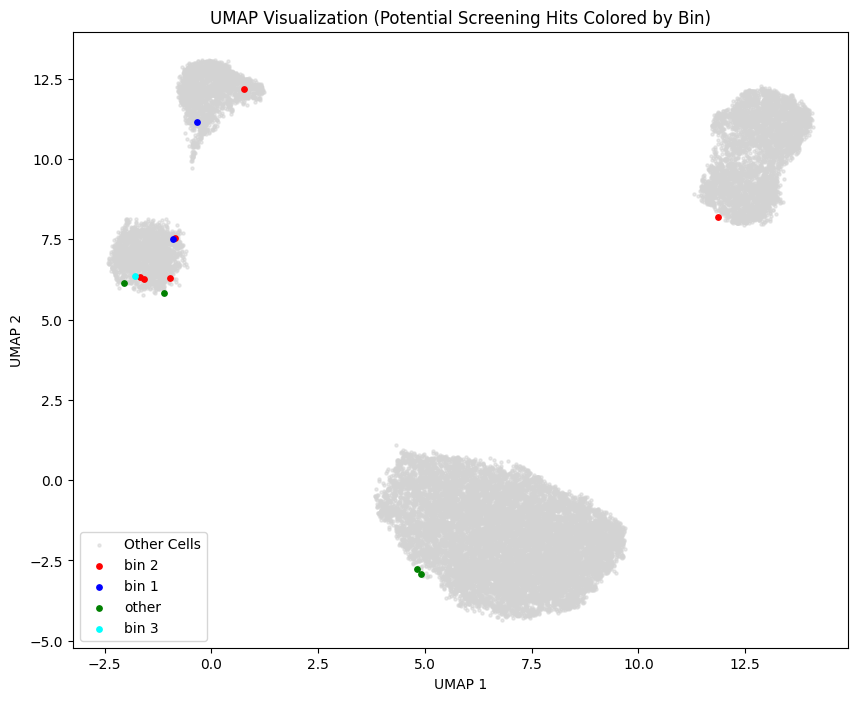

In [83]:
# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot all cells in light grey
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='lightgrey', s=5, alpha=0.5, label="Other Cells")

# Overlay highlighted screening cells in their bin colors
for i, bin_label in enumerate(highlighted_bins):
    plt.scatter(highlighted_x[i], highlighted_y[i], color=bin_colors[bin_label], s=15, label=bin_label if bin_label not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.title('UMAP Visualization (Potential Screening Hits Colored by Bin)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(False)
plt.show()

In [84]:
df

,Cell ID,Autophagy On Score,Autophagy Off Score,Bin
0,439,6.700127e-02,9.329987e-01,other
1,293873,5.018042e-07,9.999995e-01,bin 1
2,1437,7.523392e-01,2.476609e-01,other
3,437630,1.878466e-06,9.999981e-01,bin 1
4,80815,9.999956e-01,4.432396e-06,other
...,...,...,...,...
11995,469873,9.998048e-01,1.952647e-04,other
11996,316062,3.255916e-05,9.999675e-01,bin 2
11997,179090,9.619690e-01,3.803107e-02,other
11998,247275,2.832826e-06,9.999971e-01,bin 1


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


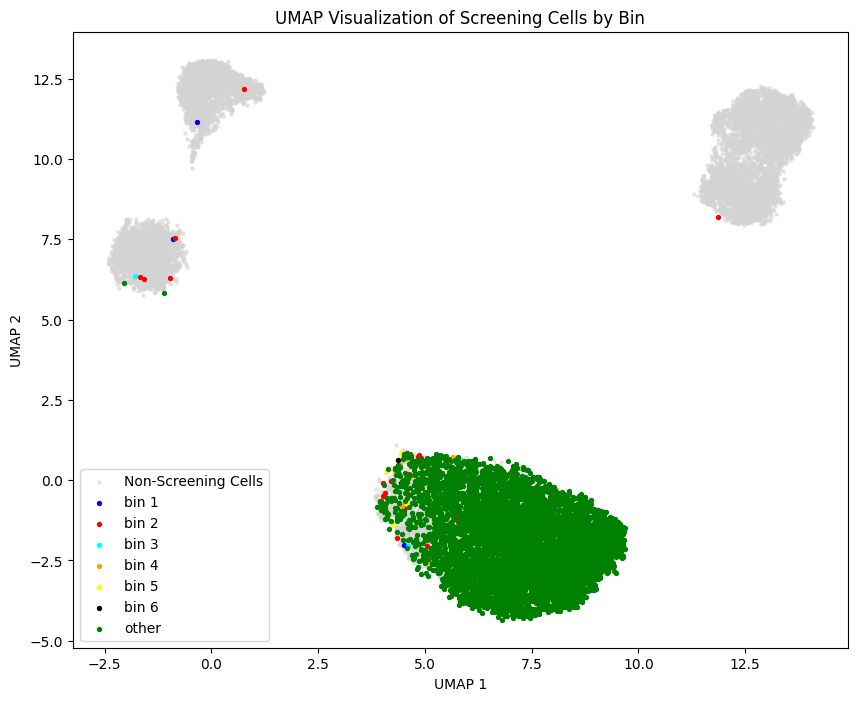

In [85]:
import os
import pickle
import numpy as np
import pandas as pd
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/"
file_name = "semisupervised_case3.pkl"
file_path = os.path.join(save_path, file_name)

with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

# Flatten embeddings for UMAP
dim_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = dim_reducer.fit_transform(embeddings.reshape(embeddings.shape[0], -1))

# Load classification scores
df = pd.read_csv("autophagy21_classification_scores_big_testset.csv")
df["Cell ID"] = df["Cell ID"].astype(str)

# Define binning function
def assign_bin(score):
    if score > 0.99999:
        return "bin 1"
    elif score > 0.999:
        return "bin 2"
    elif score > 0.9975:
        return "bin 3"
    elif score > 0.995:
        return "bin 4"
    elif score > 0.99:
        return "bin 5"
    elif score > 0.98:
        return "bin 6"
    else:
        return "other"

# Assign bins
df["Bin"] = df["Autophagy Off Score"].apply(assign_bin)

# Create a mapping from Cell ID to bin values
cell_id_to_bin = dict(zip(df["Cell ID"], df["Bin"]))

# Identify screening cells
screening_idx = labels_list == 5
screening_cell_ids = [str(cell_id) for cell_id in cell_ids_list[screening_idx]]

# Extract bin values for screening cells
screening_bins = [cell_id_to_bin.get(cid, "Unknown") for cid in screening_cell_ids]

# Define a color palette for bins
bin_palette = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black",
    "other": "green"
}

# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot non-screening cells in grey
non_screening_idx = ~screening_idx
plt.scatter(umap_result[non_screening_idx, 0], umap_result[non_screening_idx, 1],
            color='lightgrey', alpha=0.5, s=5, label="Non-Screening Cells")

# Plot screening cells with bin colors
for bin_label, color in bin_palette.items():
    bin_indices = [i for i, b in enumerate(screening_bins) if b == bin_label]
    if bin_indices:
        plt.scatter(umap_result[screening_idx][bin_indices, 0], 
                    umap_result[screening_idx][bin_indices, 1],
                    color=color, s=8, label=bin_label)

plt.legend()
plt.title("UMAP Visualization of Screening Cells by Bin")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)

# Save the plot
output_path = "./semisupervised_convnext/umap_plot_screening_cells_by_bin.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

In [19]:
# Training data is MPCDF screening data with bin information and the dir labels are the bins!
MPCDF_screening_testdata = HDF5SingleCellDataset(
    dir_list=['/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_1/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_2/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_3/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_4/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_5/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_6/single_cells_subsetted.h5'
    ],
    dir_labels=[1, 2, 3, 4, 5, 6],  # Bin labels
    root_dir='/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/',
    select_channel=4,  # Select the 5th channel
    return_id=True
)

Total: 60000
1: 10000
2: 10000
3: 10000
4: 10000
5: 10000
6: 10000


In [20]:
test_data_loader = DataLoader(MPCDF_screening_testdata, batch_size=64, shuffle=True, num_workers=8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [21]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1) 

In [23]:
embeddings = []
labels_list = []
cell_ids_list = []  

model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        inputs, labels, cell_ids = batch  
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Convert inputs from single-channel to 3 channels
        inputs = convert_to_rgb(inputs)


        # Forward pass to get logits and pooler output
        _, pooler_output, _ = model(inputs)

        # Append pooler_output, labels, and cell_ids
        embeddings.append(pooler_output.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        cell_ids_list.append(cell_ids.cpu().detach().numpy())  

# Convert to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0) 

In [24]:
# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

# Define new class labels 
class_labels = ["Bin 1", "Bin 2", "Bin 3", "Bin 4", "Bin 5", "Bin 6"]

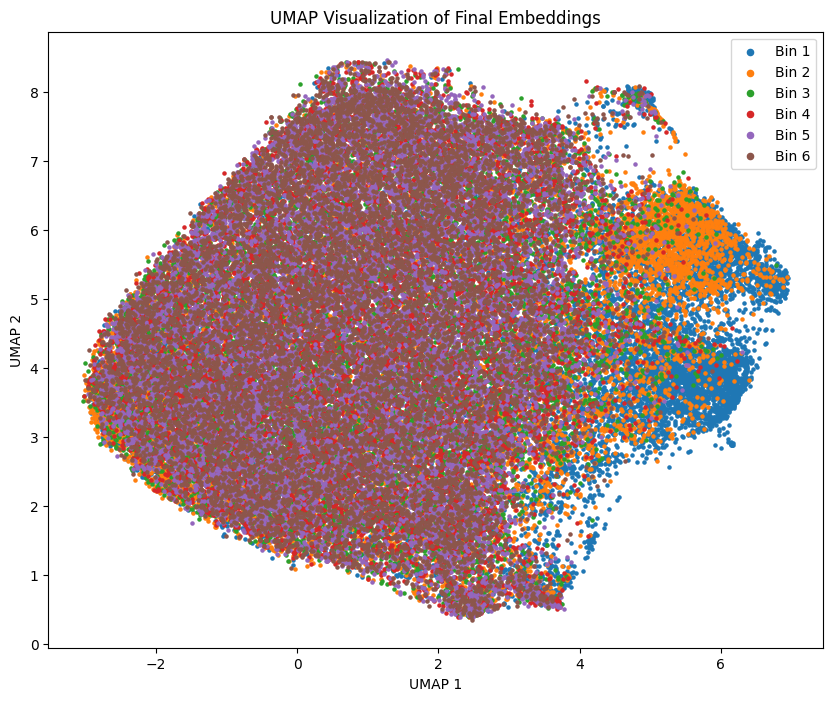

In [25]:
plt.figure(figsize=(10, 8))

labels_list = labels_list - 1

for i, label in enumerate(class_labels):
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)

plt.legend(markerscale=2)  # Makes legend dots larger
plt.title('UMAP Visualization of Final Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Save the image to a file
save_path = "./semisupervised_convnext/confusion_matrix_testset_big.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.close()  # Close the figure to prevent overlapping issues

In [32]:
# Load saved image
image = Image.open(save_path)
image = np.array(image)  # Convert to numpy array

# Create a TensorBoard writer
tensorboard_writer = SummaryWriter("runs/cell_classification")

# Convert the numpy image to a tensor format and log it
tensorboard_writer.add_image("Confusion Matrix", torch.tensor(image).permute(2, 0, 1), dataformats="CHW")

# Close the writer
tensorboard_writer.close()

## Run with tinged weight losses and run again

* Reduce classification loss weight slightly (e.g., decrease from 1.0 to 0.75).

* Increase reconstruction loss weight (increase the final weight from 0.5 to 1.0).

In [14]:
# New TensorBoard writer to avoid overwriting
tensorboard_writer = SummaryWriter("runs/cell_classification_v2")  

In [21]:
# New reconstruction loss scaling
initial_weight = 0.1  
final_weight = 1.0  # Increase the final weight to 1.0 to force more attention on reconstruction
classification_weight = 0.75  # Reduce the importance of classification loss slightly

total_epochs = 2

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=1e-5)
classification_criterion = nn.CrossEntropyLoss()
mse_criterion = nn.MSELoss()

In [22]:
# Training loop with adjusted loss weights
for epoch in range(total_epochs):
    print(f"Epoch {epoch + 1}/{total_epochs}")
    
    # Track all metrics
    all_train_labels, all_train_preds = [], []
    
    for batch_idx, (inputs, labels, _) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = convert_to_rgb(inputs)  

        optimizer.zero_grad()
        logits, _, reconstructed_image = model(inputs)

        # Classification loss (now weighted by classification_weight)
        classification_mask = labels != 5
        classification_loss = classification_criterion(logits[classification_mask], labels[classification_mask]) if classification_mask.any() else torch.tensor(0.0, device=device)
        classification_loss *= classification_weight  # Scale classification loss
        
        # Reconstruction loss (with scaling based on epoch)
        reconstruction_loss = mse_criterion(reconstructed_image, inputs)  
        epoch_factor = min(epoch / total_epochs, 1.0)
        reconstruction_loss_weight = initial_weight + (final_weight - initial_weight) * epoch_factor
        reconstruction_loss *= reconstruction_loss_weight  # Scale reconstruction loss

        total_loss = classification_loss + reconstruction_loss

        total_loss.backward()
        optimizer.step()

        # Track predictions and labels
        preds = logits.argmax(dim=1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())

        # Log metrics per batch
        tensorboard_writer.add_scalar("Loss/classification", classification_loss.item(), batch_idx + epoch * len(train_loader))
        tensorboard_writer.add_scalar("Loss/reconstruction", reconstruction_loss.item(), batch_idx + epoch * len(train_loader))
        tensorboard_writer.add_scalar("Loss/total", total_loss.item(), batch_idx + epoch * len(train_loader))
    
    # Compute metrics per epoch
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_bal_acc = balanced_accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_precision = precision_score(all_train_labels, all_train_preds, average='macro')
    train_recall = recall_score(all_train_labels, all_train_preds, average='macro')

    # Log metrics per epoch
    tensorboard_writer.add_scalar("Metrics/train_accuracy", train_acc, epoch)
    tensorboard_writer.add_scalar("Metrics/train_balanced_accuracy", train_bal_acc, epoch)
    tensorboard_writer.add_scalar("Metrics/train_f1", train_f1, epoch)
    tensorboard_writer.add_scalar("Metrics/train_precision", train_precision, epoch)
    tensorboard_writer.add_scalar("Metrics/train_recall", train_recall, epoch)

    print(f"Train Accuracy: {train_acc:.4f}, Balanced Accuracy: {train_bal_acc:.4f}, F1 Score: {train_f1:.4f}")


Epoch 1/2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 0.3145, Balanced Accuracy: 0.6290, F1 Score: 0.3744
Epoch 2/2
Train Accuracy: 0.3490, Balanced Accuracy: 0.6980, F1 Score: 0.5231


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Save
torch.save(model.state_dict(), "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_model/semisupervised_cell_model_case_3_v2.pth") # Save weights only

In [24]:
# Load the saved weights
checkpoint_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_model/semisupervised_cell_model_case_3_v2.pth"

model.load_state_dict(torch.load(checkpoint_path))
model.to(device)

ConvNextWithCustomFCandDecoder(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=T

In [25]:
#Inference
model.eval()

# Initialize tensorboard
tensorboard_writer = SummaryWriter("runs/cell_classification_v2")


#lists for storing stuff
embeddings = []
labels_list = []
cell_ids_list = []
all_labels, all_preds = [], []

with torch.no_grad():
    for inputs, labels, cell_ids in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = convert_to_rgb(inputs) 

        # Extract embeddings & logits from model
        logits, embedding_output, _ = model(inputs)
        preds = logits.argmax(dim=1)

        # Store data
        embeddings.append(embedding_output.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        cell_ids_list.append(cell_ids.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0)

# Compute Test Metrics
test_acc = accuracy_score(all_labels, all_preds)
test_bal_acc = balanced_accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')
test_precision = precision_score(all_labels, all_preds, average='macro')
test_recall = recall_score(all_labels, all_preds, average='macro')

#Log Metrics to TensorBoard
tensorboard_writer.add_scalar("Metrics/test_accuracy", test_acc)
tensorboard_writer.add_scalar("Metrics/test_balanced_accuracy", test_bal_acc)
tensorboard_writer.add_scalar("Metrics/test_f1", test_f1)
tensorboard_writer.add_scalar("Metrics/test_precision", test_precision)
tensorboard_writer.add_scalar("Metrics/test_recall", test_recall)

print(f"Test Accuracy: {test_acc:.4f}, Balanced Accuracy: {test_bal_acc:.4f}, F1 Score: {test_f1:.4f}")

Test Accuracy: 0.2842, Balanced Accuracy: 0.4736, F1 Score: 0.2980


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# Save embeddings, labels, and cell IDs
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/"
file_name = "semisupervised_case3_v2.pkl"
os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, file_name), 'wb') as f:
    pickle.dump({'embeddings': embeddings, 'labels': labels_list, 'cell_ids': cell_ids_list}, f)

print(f"Saved embeddings, labels, and cell_ids to {os.path.join(save_path, file_name)}")

Saved embeddings, labels, and cell_ids to /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/semisupervised_case3_v2.pkl


In [87]:
# Define the save path and file name
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/"
file_name = "semisupervised_case3_v2.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

Loaded embeddings shape: (20000, 2048)
Loaded labels shape: (20000,)
Loaded cell_ids shape: (20000,)


In [88]:
# UMAP
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(embeddings_flat)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


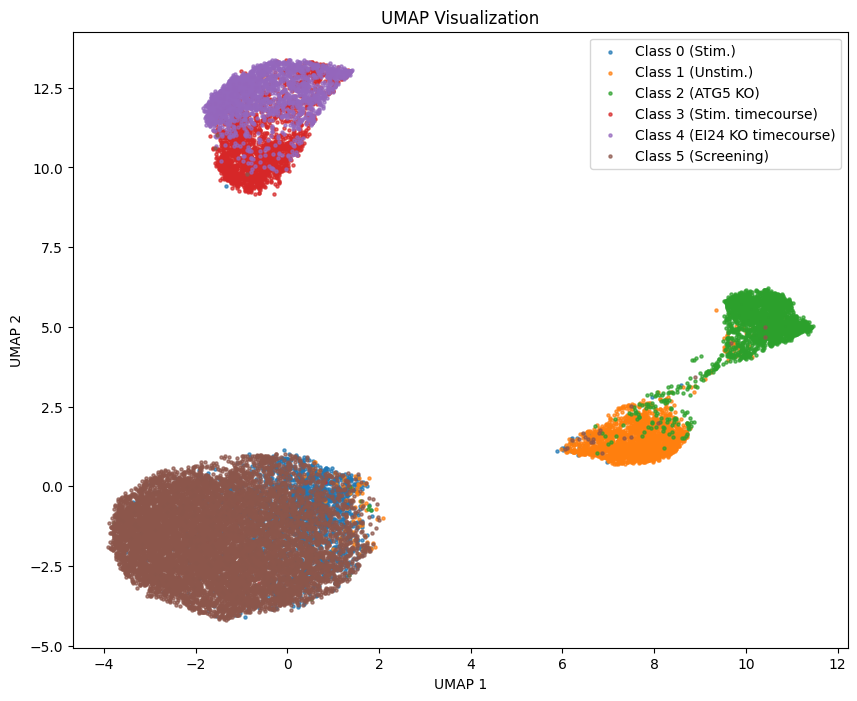

In [89]:
# Class labels
class_labels = [
    "Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 KO)", 
    "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"
]

plt.figure(figsize=(10, 8))

for i, label in enumerate(class_labels):
    idx = labels_list == i 
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5, alpha=0.7)

plt.legend()
plt.title("UMAP Visualization")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Remove grid
plt.grid(False)
plt.show()

In [90]:
#Save UMAP
umap_save_path = "./semisupervised_convnext/umap_testset_10k_v2.png"
plt.savefig(umap_save_path, bbox_inches='tight', dpi=300)
plt.close()  

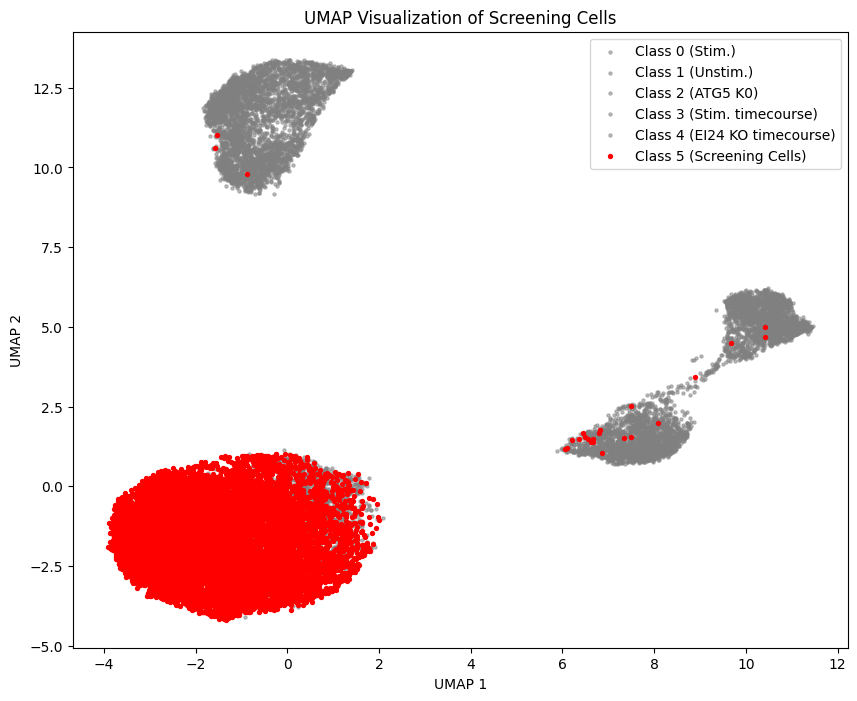

In [91]:
# Class labels
class_labels = [
    "Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", 
    "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"
]

plt.figure(figsize=(10, 8))

# Plot all other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Excluding "Screening" class
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5, alpha=0.5)

# Plot Screening cells in red
screening_idx = labels_list == 5
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], color='red', label='Class 5 (Screening Cells)', s=8)
plt.legend()
plt.title("UMAP Visualization of Screening Cells")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Remove grid
plt.grid(False)
plt.show()

In [92]:
class_labels = [
    "Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", 
    "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"
]

# Parameters for kNN and Outlier Detection
k = 10  # number of nearest neighbors
n = 20  # number of outliers to find

# Extract the UMAP result and labels
x_coords = np.asarray(umap_result[:, 0])
y_coords = np.asarray(umap_result[:, 1])
labels = np.asarray(labels_list)
cell_ids_array = np.asarray(cell_ids_list, dtype=str)

# Identify screening cells (Class 5)
screening_idx = labels == 5
screening_coords = np.column_stack((x_coords[screening_idx], y_coords[screening_idx]))

# Find the dense cluster of screening cells (non-hit control) using kNN
nbrs = NearestNeighbors(n_neighbors=k).fit(screening_coords)
distances, _ = nbrs.kneighbors(screening_coords)

# Compute the mean distance to k nearest neighbors for each cell
avg_knn_dist = distances.mean(axis=1)

# Identify the top n outliers with the biggest kNN distances
outlier_indices = np.argsort(avg_knn_dist)[-n:]

# Get the cell IDs of the outliers
outlier_cell_ids = cell_ids_array[screening_idx][outlier_indices] 

In [93]:
# Save outlier cell IDs to a file
save_path = "./semisupervised_convnext/knn_screening_hits_v2.txt"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.savetxt(save_path, outlier_cell_ids, fmt="%s")
print(f"Saved {len(outlier_cell_ids)} potential screening hits to {save_path}")

Saved 20 potential screening hits to ./semisupervised_convnext/knn_screening_hits_v2.txt


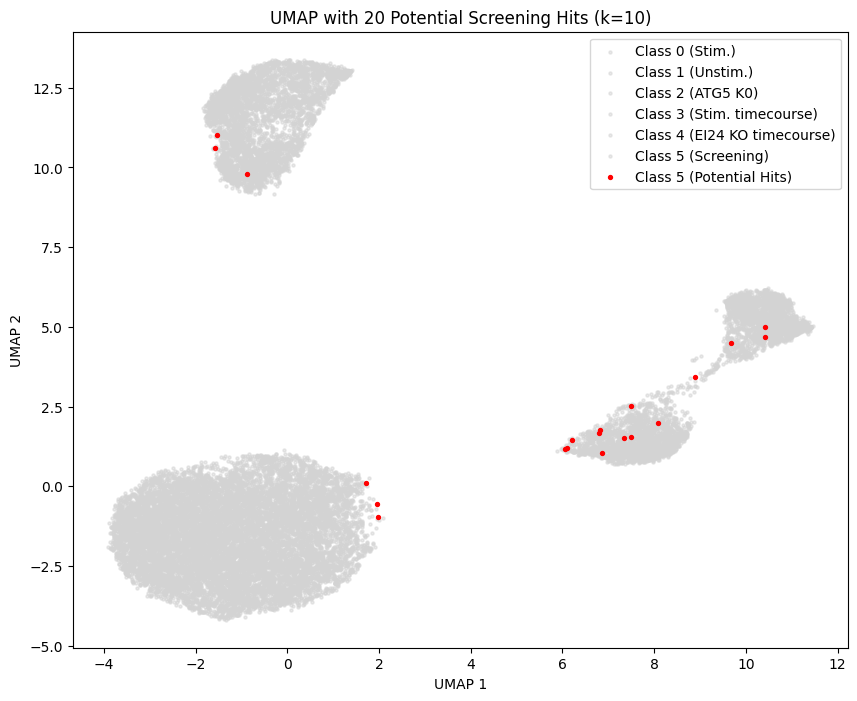

In [94]:
# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot all classes (including screening) in light grey
for i, label in enumerate(class_labels):  
    idx = labels == i
    plt.scatter(x_coords[idx], y_coords[idx], color='lightgrey', label=label, s=5, alpha=0.5)

# Plot Screening cells that are identified as potential hits using kNN in red
plt.scatter(screening_coords[outlier_indices, 0], screening_coords[outlier_indices, 1], 
            color='red', label="Class 5 (Potential Hits)", s=8, edgecolors='red')
plt.legend()
plt.title(f"UMAP with {n} Potential Screening Hits (k={k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.show()

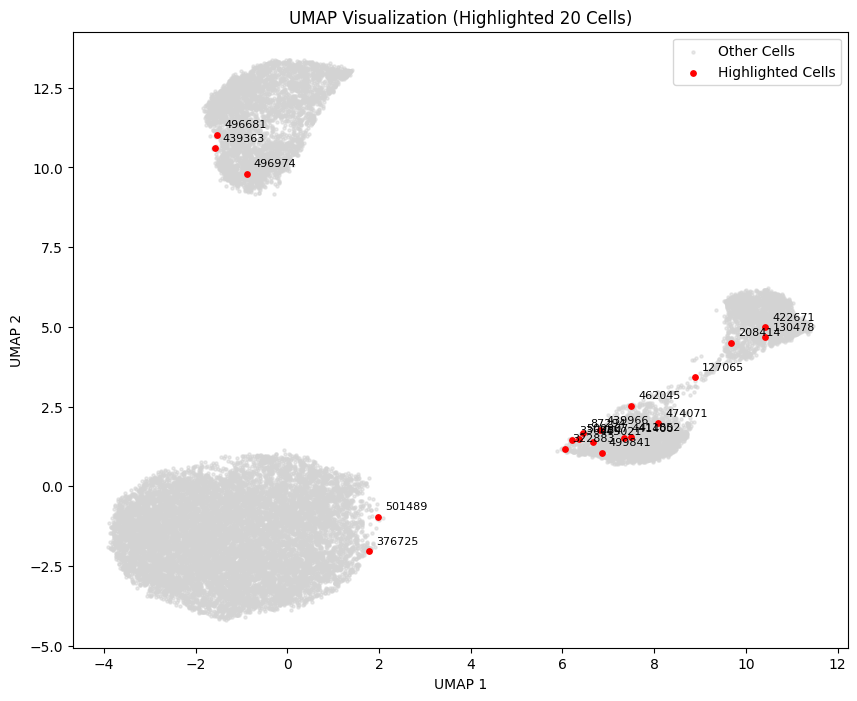

In [95]:
highlighted_cell_ids = np.array([208414,
376725,
500807,
441400,
87294,
411852,
499841,
422671,
439966,
501489,
496681,
322883,
445021,
336884,
474071,
439363,
462045,
127065,
496974,
130478]
).astype(str)  

cell_ids_array = cell_ids_array.astype(str)
highlighted_indices = np.isin(cell_ids_array, highlighted_cell_ids)

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='lightgrey', label="Other Cells", s=5, alpha=0.5)

plt.scatter(highlighted_x, highlighted_y, color='red', edgecolors='red', s=15, label='Highlighted Cells', marker='o')

for i, txt in enumerate(highlighted_cell_ids):
    plt.annotate(txt, (highlighted_x[i], highlighted_y[i]), fontsize=8, color='black', xytext=(5,5), textcoords='offset points')

plt.legend()
plt.title('UMAP Visualization (Highlighted 20 Cells)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

['499841', '500807', '344051', '376324', '498330', '411852', '494847', '501489', '439966', '496681', '322883', '336884', '474071', '439363', '462045', '127065', '496974', '130478', '87294', '422671']
Loaded 20 outlier cell IDs from ./semisupervised_convnext/knn_screening_hits_v2.txt
Outlier Cell Images (20 total)
Saved outlier cell images to ./semisupervised_convnext/knn_screening_hits_images_v2.png


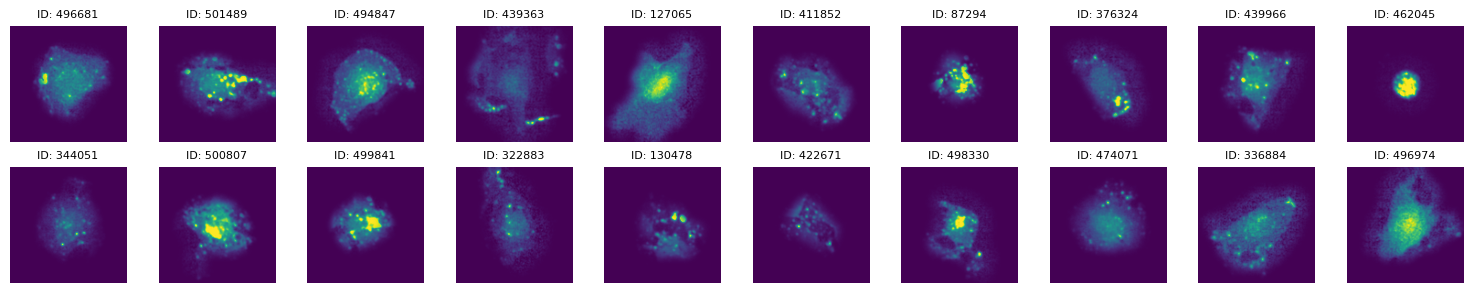

In [96]:
# Load the outlier cell IDs from the saved text file!
knn_outlier_file = "./semisupervised_convnext/knn_screening_hits_v2.txt"
if os.path.exists(knn_outlier_file):
    with open(knn_outlier_file, "r") as f:
        outlier_cell_ids = [line.strip() for line in f.readlines()]
        print(outlier_cell_ids)
    print(f"Loaded {len(outlier_cell_ids)} outlier cell IDs from {knn_outlier_file}")

    # **Visualize and save images for outlier cells**
    visualize_and_save_cells(outlier_cell_ids, test_data_loader, save_path="./semisupervised_convnext/knn_screening_hits_images_v2.png")
else:
    print(f"Outlier cell file not found: {knn_outlier_file}")

In [ ]:
# Load scores
scores_df = pd.read_csv("autophagy21_classification_scores_big_testset.csv")

# Load outlier cell IDs
knn_outlier_file = "./semisupervised_convnext/knn_screening_hits_v2.txt"
if os.path.exists(knn_outlier_file):
    with open(knn_outlier_file, "r") as f:
        outlier_cell_ids = [line.strip() for line in f.readlines()]
        print(f"Loaded {len(outlier_cell_ids)} outlier cell IDs.")

    visualize_and_save_cells(outlier_cell_ids, test_data_loader, scores_df, save_path="./semisupervised_convnext/knn_screening_hits_images_v2.png")
else:
    print(f"Outlier cell file not found: {knn_outlier_file}")


Loaded 20 outlier cell IDs.
Outlier Cell Images (20 total)
Saved outlier cell images to ./semisupervised_convnext/knn_screening_hits_images_v2.png


In [97]:
import numpy as np
import pandas as pd
import umap
import umap.umap_ as umap  # Correct way
import matplotlib.pyplot as plt

# Define binning function based on autophagy_off score
def assign_bin(score):
    if score > 0.99999:
        return "bin 1"
    elif score > 0.999:
        return "bin 2"
    elif score > 0.9975:
        return "bin 3"
    elif score > 0.995:
        return "bin 4"
    elif score > 0.99:
        return "bin 5"
    elif score > 0.98:
        return "bin 6"
    else:
        return "other"

    
# Step 2: Apply binning function to create a new column
df = pd.read_csv("autophagy21_classification_scores_big_testset.csv")
df

cell_ids_to_find = ["208414", "376725", "500807", "441400", "87294", 
               "411852", "499841", "422671", "439966", "501489", 
               "496681", "322883", "445021", "336884", "474071", 
               "439363", "462045", "127065", "496974", "130478"]

# Apply binning function to the dataframe
df["Bin"] = df["Autophagy Off Score"].apply(assign_bin)
df["Cell ID"] = df["Cell ID"].astype(str)
df

,Cell ID,Autophagy On Score,Autophagy Off Score,Bin
0,439,6.700127e-02,9.329987e-01,other
1,293873,5.018042e-07,9.999995e-01,bin 1
2,1437,7.523392e-01,2.476609e-01,other
3,437630,1.878466e-06,9.999981e-01,bin 1
4,80815,9.999956e-01,4.432396e-06,other
...,...,...,...,...
11995,469873,9.998048e-01,1.952647e-04,other
11996,316062,3.255916e-05,9.999675e-01,bin 2
11997,179090,9.619690e-01,3.803107e-02,other
11998,247275,2.832826e-06,9.999971e-01,bin 1


In [98]:
# Merge bin information into filtered_df
filtered_df = df[df["Cell ID"].isin(cell_ids_to_find)]
filtered_df

,Cell ID,Autophagy On Score,Autophagy Off Score,Bin
908,439966,9.962118e-01,0.003788,other
1218,322883,6.764363e-04,0.999324,bin 2
4315,130478,9.773184e-01,0.022682,other
4972,445021,1.338151e-04,0.999866,bin 2
6177,422671,9.394946e-01,0.060505,other
6203,499841,2.958022e-01,0.704198,other
6329,441400,2.105678e-04,0.999789,bin 2
7574,439363,2.535472e-04,0.999746,bin 2
7681,474071,5.001426e-05,0.999950,bin 2
7750,496681,5.460521e-04,0.999454,bin 2


In [99]:
# Extract indices of highlighted screening cells
cell_ids_array = cell_ids_list.astype(str)  # Convert all cell IDs to string
highlighted_indices = np.isin(cell_ids_array, filtered_df["Cell ID"].values)  # Boolean mask

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

# Merge UMAP results with bin information
highlighted_bins = filtered_df.set_index("Cell ID").loc[cell_ids_array[highlighted_indices], "Bin"].values

# Define colors for bins
bin_colors = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black", 
    "other": "green"
}

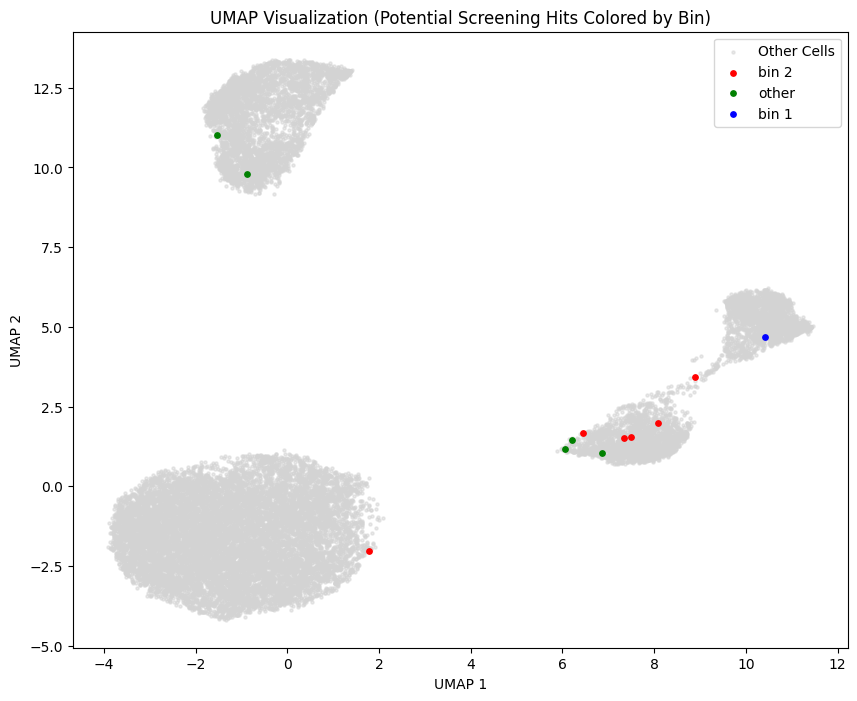

In [100]:
# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot all cells in light grey
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='lightgrey', s=5, alpha=0.5, label="Other Cells")

# Overlay highlighted screening cells in their bin colors
for i, bin_label in enumerate(highlighted_bins):
    plt.scatter(highlighted_x[i], highlighted_y[i], color=bin_colors[bin_label], s=15, label=bin_label if bin_label not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.title('UMAP Visualization (Potential Screening Hits Colored by Bin)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(False)
plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


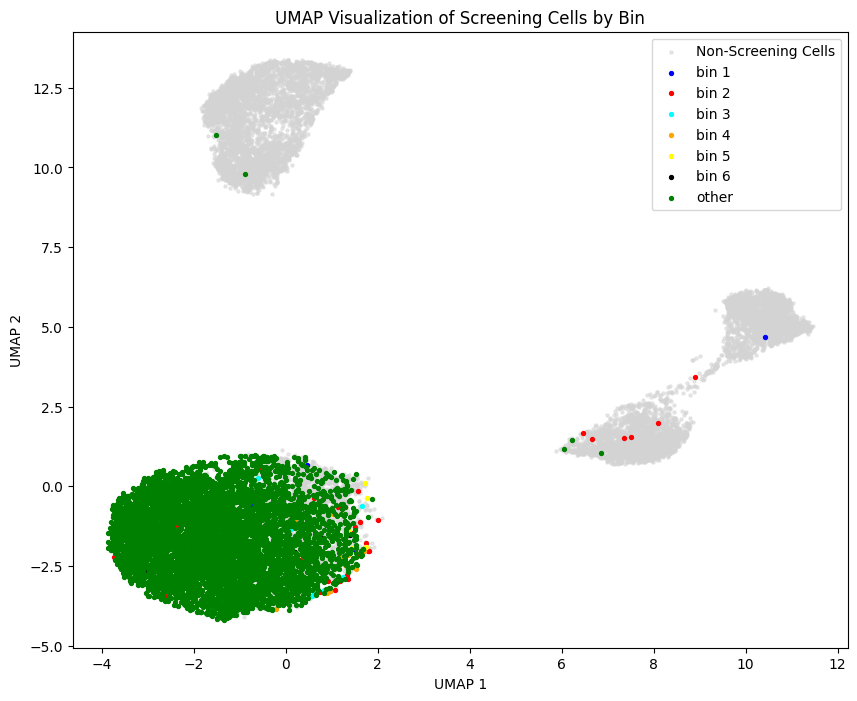

In [101]:
import os
import pickle
import numpy as np
import pandas as pd
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/"
file_name = "semisupervised_case3_v2.pkl"
file_path = os.path.join(save_path, file_name)

with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

# Flatten embeddings for UMAP
dim_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = dim_reducer.fit_transform(embeddings.reshape(embeddings.shape[0], -1))

# Load classification scores
df = pd.read_csv("autophagy21_classification_scores_big_testset.csv")
df["Cell ID"] = df["Cell ID"].astype(str)

# Define binning function
def assign_bin(score):
    if score > 0.99999:
        return "bin 1"
    elif score > 0.999:
        return "bin 2"
    elif score > 0.9975:
        return "bin 3"
    elif score > 0.995:
        return "bin 4"
    elif score > 0.99:
        return "bin 5"
    elif score > 0.98:
        return "bin 6"
    else:
        return "other"

# Assign bins
df["Bin"] = df["Autophagy Off Score"].apply(assign_bin)

# Create a mapping from Cell ID to bin values
cell_id_to_bin = dict(zip(df["Cell ID"], df["Bin"]))

# Identify screening cells
screening_idx = labels_list == 5
screening_cell_ids = [str(cell_id) for cell_id in cell_ids_list[screening_idx]]

# Extract bin values for screening cells
screening_bins = [cell_id_to_bin.get(cid, "Unknown") for cid in screening_cell_ids]

# Define a color palette for bins
bin_palette = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black",
    "other": "green"
}

# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot non-screening cells in grey
non_screening_idx = ~screening_idx
plt.scatter(umap_result[non_screening_idx, 0], umap_result[non_screening_idx, 1],
            color='lightgrey', alpha=0.5, s=5, label="Non-Screening Cells")

# Plot screening cells with bin colors
for bin_label, color in bin_palette.items():
    bin_indices = [i for i, b in enumerate(screening_bins) if b == bin_label]
    if bin_indices:
        plt.scatter(umap_result[screening_idx][bin_indices, 0], 
                    umap_result[screening_idx][bin_indices, 1],
                    color=color, s=8, label=bin_label)

plt.legend()
plt.title("UMAP Visualization of Screening Cells by Bin")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)

# Save the plot
output_path = "./semisupervised_convnext/umap_plot_screening_cells_by_bin_v2.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

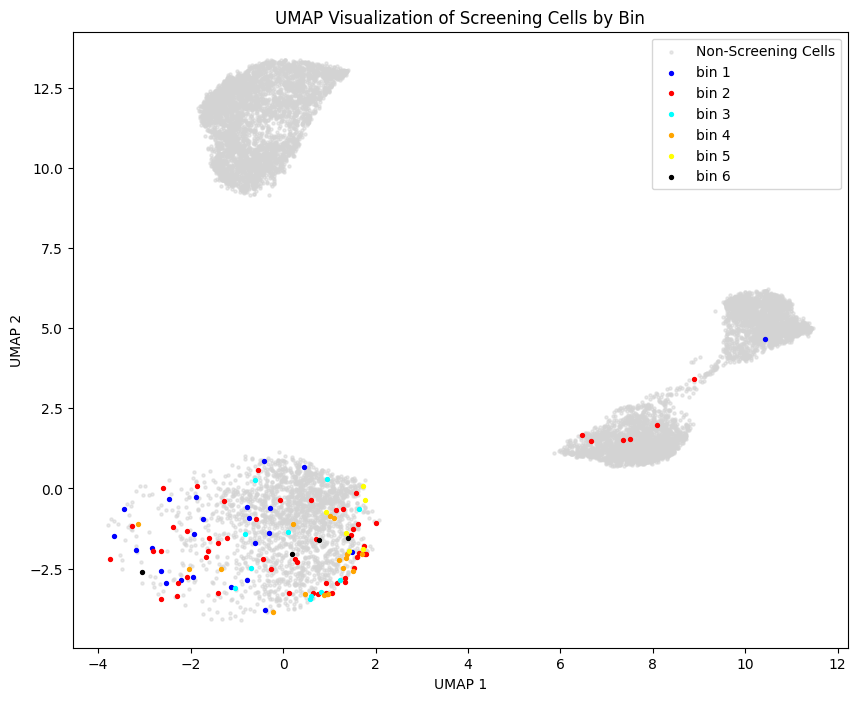

In [102]:
# Define a color palette for bins
bin_palette = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black"
}

# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot non-screening cells in grey
non_screening_idx = ~screening_idx
plt.scatter(umap_result[non_screening_idx, 0], umap_result[non_screening_idx, 1],
            color='lightgrey', alpha=0.5, s=5, label="Non-Screening Cells")

# Plot screening cells with bin colors
for bin_label, color in bin_palette.items():
    bin_indices = [i for i, b in enumerate(screening_bins) if b == bin_label]
    if bin_indices:
        plt.scatter(umap_result[screening_idx][bin_indices, 0], 
                    umap_result[screening_idx][bin_indices, 1],
                    color=color, s=8, label=bin_label)

plt.legend()
plt.title("UMAP Visualization of Screening Cells by Bin")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.show()

In [41]:
# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Save the image to a file
save_path = "./semisupervised_convnext/confusion_matrix_testset_big_v2.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.close()  # Close the figure to prevent overlapping issues

In [42]:
# Load saved image
image = Image.open(save_path)
image = np.array(image)  # Convert to numpy array

# Create a TensorBoard writer
tensorboard_writer = SummaryWriter("runs/cell_classification_v2")

# Convert the numpy image to a tensor format and log it
tensorboard_writer.add_image("Confusion Matrix", torch.tensor(image).permute(2, 0, 1), dataformats="CHW")

# Close the writer
tensorboard_writer.close()

## Check for overlap with supervised runs

In [3]:
# Print the number of saved cell IDs per file
file_paths = {
    "ConvNeXt case 1 - 1000 cells": "./convnext_output_files/case1_1000_cells_outside_block_screening_hits.txt",
    #"ConvNeXt case 1 - 100000 cells": "./convnext_output_files/case1_100000_cells_outside_block_screening_hits.txt",
    "ConvNeXt case 2 - 1000 cells": "./convnext_output_files/case2_1000_cells_outside_block_screening_hits.txt",
    "De novo case 1 - 100000 cells": "./de_novo_output_files/de_novo_outside_block_screening_hits.txt",
    "Semisupervised case 3 - 10000 screening cells": "./semisupervised_convnext/knn_screening_hits_v2.txt"
}

# Load cell IDs from files
cell_id_sets = {key: set(np.loadtxt(path, dtype=int)) for key, path in file_paths.items()}

print("Cell ID counts per file:")
for key, cell_ids in cell_id_sets.items():
    print(f"{key}: {len(cell_ids)} cell IDs")

Cell ID counts per file:
ConvNeXt case 1 - 1000 cells: 21 cell IDs
ConvNeXt case 2 - 1000 cells: 26 cell IDs
De novo case 1 - 100000 cells: 46 cell IDs
Semisupervised case 3 - 10000 screening cells: 20 cell IDs


In [4]:
def visualize_and_save_cells(overlapping_cell_ids, data_loader, save_path="./convnext_output_files/overlapping_cell_images.png"):
    """Visualizes images for the overlapping cell IDs in a dynamic grid, saves, and shows the result."""
    if not overlapping_cell_ids:
        print("No overlapping cell images to visualize.")
        return

    overlapping_cell_ids = list(overlapping_cell_ids)
    num_images = len(overlapping_cell_ids)
    
    # Dynamically determine grid size (rows, cols) to fit all images
    grid_cols = 10 
    grid_rows = int(np.ceil(num_images / grid_cols))  
    
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 1.5 * grid_rows))

    image_count = 0
    for images, labels, cell_ids in data_loader:
        for i in range(len(cell_ids)):
            if cell_ids[i].item() in overlapping_cell_ids:
                row, col = divmod(image_count, grid_cols)
                ax = axes[row, col] if grid_rows > 1 else axes[col]

                image_data = images[i].numpy()
                num_channels = image_data.shape[0]

                # If single-channel, show grayscale image
                if num_channels == 1:
                    ax.imshow(image_data[0], cmap='viridis')
                else:
                    ax.imshow(np.moveaxis(image_data, 0, -1))  # Reorder channels!!

                ax.set_title(f"ID: {cell_ids[i].item()}", fontsize=8)
                ax.axis("off")

                image_count += 1
                if image_count >= num_images:  
                    break  

        if image_count >= num_images:
            break  

    # Hide unused subplots
    for ax in axes.flat[image_count:]:
        ax.axis("off")

    plt.tight_layout()
    plt.title(f"Overlapping Cell Images ({num_images} total)", fontsize=10)
    
    # Save 
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Saved overlapping cell images to {save_path}")
    plt.show()

In [47]:
# Find overlapping cell IDs among ConvNeXt case 1, ConvNeXt case 2, De novo case 1, and Semisupervised case 3
overlapping_all = (
    cell_id_sets["ConvNeXt case 1 - 1000 cells"] & 
    cell_id_sets["ConvNeXt case 2 - 1000 cells"] & 
    cell_id_sets["De novo case 1 - 100000 cells"] & 
    cell_id_sets["Semisupervised case 3 - 10000 screening cells"]
)

# Ensure it's not empty
if overlapping_all:
    visualize_and_save_cells(overlapping_all, test_data_loader)
else:
    print("No overlapping cell images found among ConvNeXt, De novo, and Semisupervised cases.")

No overlapping cell images found among ConvNeXt, De novo, and Semisupervised cases.


<Figure size 800x600 with 0 Axes>

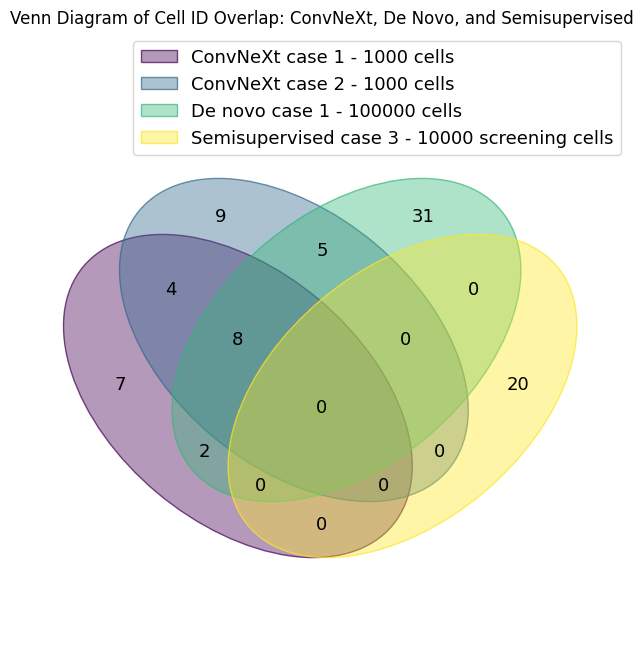

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from venn import venn

# File paths and loading cell IDs as sets
file_paths = {
    "ConvNeXt case 1 - 1000 cells": "./convnext_output_files/case1_1000_cells_outside_block_screening_hits.txt",
    "ConvNeXt case 2 - 1000 cells": "./convnext_output_files/case2_1000_cells_outside_block_screening_hits.txt",
    "De novo case 1 - 100000 cells": "./de_novo_output_files/de_novo_outside_block_screening_hits.txt",
    "Semisupervised case 3 - 10000 screening cells": "./semisupervised_convnext/knn_screening_hits_v2.txt"
}

# Load cell IDs from files
cell_id_sets = {key: set(np.loadtxt(path, dtype=int)) for key, path in file_paths.items()}

# Create Venn diagram with all four sets
plt.figure(figsize=(8, 6))
venn(cell_id_sets)

# Title and display the updated Venn diagram
plt.title("Venn Diagram of Cell ID Overlap: ConvNeXt, De Novo, and Semisupervised")
plt.show()

In [5]:
file_paths = {
    "ConvNeXt case 1": "./convnext_output_files/case1_1000_cells_outside_block_screening_hits_big_testset.txt",
    #"ConvNeXt case 1 - 100000 cells": "./convnext_output_files/case1_100000_cells_outside_block_screening_hits_big.txt",
    "ConvNeXt case 3": "./convnext_output_files/case2_1000_cells_outside_block_screening_hits_big.txt",
    "Multiclass autophagy classifier": "./de_novo_output_files/de_novo_outside_block_screening_hits_big.txt",
    "Semisupervised run 2": "./semisupervised_convnext/knn_screening_hits_v2.txt"
}


# Load cell IDs from files
cell_id_sets = {key: set(np.loadtxt(path, dtype=int)) for key, path in file_paths.items()}

print("Cell ID counts per file:")
for key, cell_ids in cell_id_sets.items():
    print(f"{key}: {len(cell_ids)} cell IDs")

Cell ID counts per file:
ConvNeXt case 1: 92 cell IDs
ConvNeXt case 3: 31 cell IDs
Multiclass autophagy classifier: 80 cell IDs
Semisupervised run 2: 20 cell IDs


Saved overlapping cell images to ./convnext_output_files/overlapping_cell_images.png


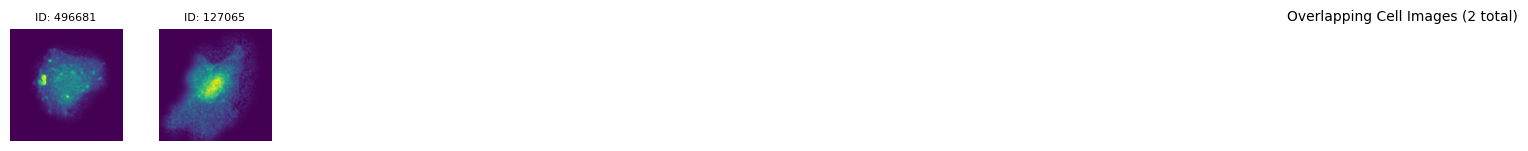

In [12]:
# Find overlapping cell IDs among ConvNeXt case 1, ConvNeXt case 2, De novo case 1, and Semisupervised case 3
overlapping_all = (
    cell_id_sets["ConvNeXt case 1"] & 
    cell_id_sets["ConvNeXt case 3"] & 
    cell_id_sets["Multiclass autophagy classifier"] & 
    cell_id_sets["Semisupervised run 2"]
)

# Ensure it's not empty
if overlapping_all:
    visualize_and_save_cells(overlapping_all, test_data_loader)
else:
    print("No overlapping cell images found among ConvNeXt, De novo, and Semisupervised cases.")

<Figure size 800x600 with 0 Axes>

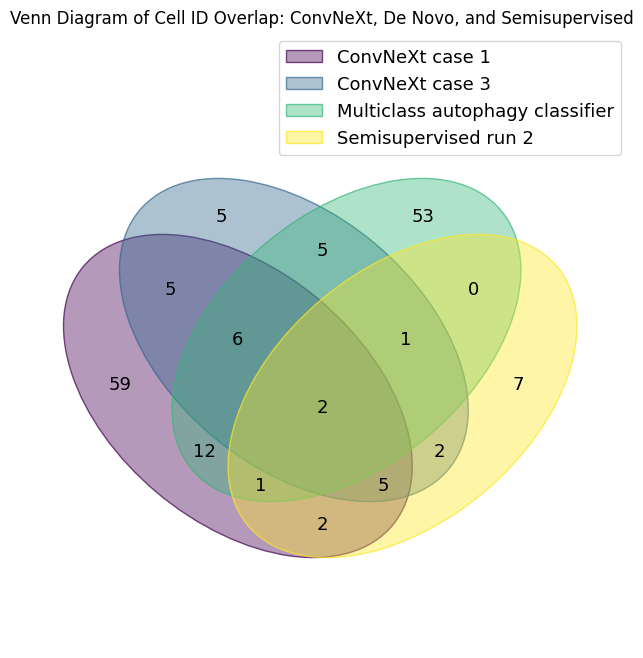

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from venn import venn

# Load cell IDs from files
cell_id_sets = {key: set(np.loadtxt(path, dtype=int)) for key, path in file_paths.items()}

# Create Venn diagram with all four sets
plt.figure(figsize=(8, 6))
venn(cell_id_sets)

# Title and display the updated Venn diagram
plt.title("Venn Diagram of Cell ID Overlap: ConvNeXt, De Novo, and Semisupervised")
plt.show()